In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
import math


from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack
import scipy

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *
from scoping.views import *

import learning_utils
import random


double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)

In [2]:
pid = 193
qid = 7638
q = Query.objects.get(pk=qid)
p = Project.objects.get(pk=pid)

other_docs = Doc.objects.filter(docproject__project=p, PY__gt=2012).exclude(query=q)

for d in other_docs:
    d.query.add(q)

q.r_count = q.doc_set.count()
q.save()
q.r_count

75173

In [3]:
q.doc_set.filter(PY=2012).count()

5

In [4]:
docs = Doc.objects.filter(query=q, content__iregex='\w').values_list('pk', flat=True)

print(docs.count())

seen = set(DocOwnership.objects.filter(
    query=q, 
    relevant__gt=0
).values_list('doc__pk', flat=True))


seen = seen & set(docs)

seen_docs = Doc.objects.filter(pk__in=seen)
seen_docs.count()

62689


9523

In [5]:
DocProject.objects.filter(project=p).values('relevant').annotate(
    n = Count('pk')
)

<QuerySet [{'relevant': 0, 'n': 105726}, {'relevant': 1, 'n': 3228}, {'relevant': 2, 'n': 6007}, {'relevant': 3, 'n': 319}]>

In [6]:
unseen_docs = docs.exclude(pk__in=seen).distinct('id')

unseen_docs.count()

columns = [
    'id',
    'content',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0

print(unseen_df.shape)
unseen_df.head()

(53166, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,46,Glaciers store water over a range of temporal ...,A review of methods for estimating the contrib...,climate change; glacier meltwater; hydrologica...,"[Geography, Physical; Geosciences, Multidiscip...",0,0
1,111,1 .Gradients in elevation are increasingly use...,Changes in host-parasitoid food web structure ...,climate change; elevation; experimental manipu...,[Ecology; Zoology],0,0
2,274,Regenerative sustainability is emerging as an ...,Regenerative sustainability for the built envi...,Regenerative sustainability; Theory; Framework...,[Green & Sustainable Science & Technology; Eng...,0,0
3,297,Grass silage is typically fed to dairy cows in...,Effects of nitrogen fertilisation rate and mat...,nitrogen fertilisation; grass maturity; ryegra...,"[Agriculture, Dairy & Animal Science; Veterina...",0,0
4,332,Mountain grassland ecosystems are particularly...,Taking into account farmers' decision making t...,Scenarios; Participatory approach; Role-playin...,[Ecology; Environmental Studies; Geography; Ge...,0,0


In [7]:
rated = list(seen_docs.values(*columns))
r_docs = []
for r in rated:
    d = Doc.objects.get(pk=r['id'])

    dos = DocOwnership.objects.filter(
        query__project=p,doc=d,relevant__gt=0,
    ).values_list('relevant',flat=True)
    if not dos.exists():
        dos = DocOwnership.objects.filter(
            project=p,doc=d,relevant__gt=0,
        ).values_list('relevant',flat=True)            
    if len(set(dos))==1: # If there is only one value (all ratings agree)
        if dos[0] == 1:
            r['relevant'] = 1
        elif dos[0] == 2 or dos[0] == 4:
            r['relevant'] = 0
        else:
            r['relevant'] = np.NaN
    else:
        r['relevant'] = np.NaN
    r_docs.append(r)
    
        
seen_df = pd.DataFrame.from_dict(r_docs)
seen_df = seen_df[columns + ["relevant"]]
seen_df['seen'] = 1
seen_df.loc[pd.isna(seen_df['relevant']),'seen'] = np.NaN
print(seen_df.shape)
seen_df.head()

(9523, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,260,Phytosanitary risks are an increasing threat f...,An economic comparison of risk handling measur...,Phytosanitary risks; Cause-oriented measures; ...,[Forestry],1.0,1.0
1,694,The effectiveness of various adaptation option...,Building adaptive capacity in South East Queen...,Adaptive capacity; Climate change; Adaptation;...,[Environmental Sciences; Environmental Studies],0.0,1.0
2,1516,The impact of climate change on agriculture ha...,A general equilibrium assessment of climate ch...,Climate change; agricultural productivity; imp...,[Economics],0.0,1.0
3,1630,Cover crops have long been touted for their ab...,Using cover crops to mitigate and adapt to cli...,Adaptive management; Agriculture; Albedo; Cove...,[Agronomy; Green & Sustainable Science & Techn...,1.0,1.0
4,1731,Management of marine mega-fauna in a changing ...,Adaptive management of marine mega-fauna in a ...,Adaptive management; Climate change; Marine me...,[Environmental Sciences],0.0,1.0


In [8]:
df = (pd.concat([seen_df,unseen_df])
      .sort_values('id')
      .reset_index(drop=True)
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
     )
y = df['relevant']

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index

df.head()

,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,2326152,Citizens' initiatives for climate action are a...,From citizen participation to government parti...,climate change adaptation; community initiativ...,[Environmental Studies],1.0,1.0
1,2152493,Hindu Kush Himalayan is facing greater threat ...,DOES LIVELIHOOD VULNERABILITY INDEX JUSTIFY TH...,climate change; natural disaster; differential...,[Ecology; Environmental Sciences],0.0,0.0
2,66091,Putting climate change policy-integration into...,Negotiating climate change responses: Regional...,Climate change; Spatial planning; Regional-loc...,[Environmental Studies],1.0,1.0
3,1859084,The Yellow River is a very difficulty river to...,Hydrological Response to Adapt Climate Changes,water resources regime changes; human activiti...,[Water Resources],0.0,0.0
4,760884,This article uses recursivity theory to examin...,Perspectives on the emerging role of the Asian...,None,[International Relations],0.0,0.0


In [ ]:
duplicateRowsDF = df[df.duplicated(['title'])]
print(duplicateRowsDF.shape)

duplicateRowsDF.head()



In [ ]:
for i, row in duplicateRowsDF.iterrows():
    if len(row['title'].split()) < 3:
        print(row['title'])
        continue
    d = Doc.objects.get(pk=row['id'])
    ds = Doc.objects.filter(
        tslug=Doc.make_tslug(d.title),
        PY=d.PY
    )
    if ds.count() > 1:
        print(ds.values('title','id'))
        try:
            wd = ds.get(UT__UT__icontains="WOS:")
            sd = ds.exclude(UT__UT__icontains="WOS:")
        except:
            wd = ds.first()
            sd = ds.exclude(pk=wd.pk)
            #print(sd)
            #continue
        
        for d in sd:
            for do in d.docownership_set.filter(query__project=p):
                if DocOwnership.objects.filter(user=do.user,doc=do.doc).exists():
                    do.delete()
                else:
                    do.doc=wd
                    do.save()
            for q in d.query.filter(project=p):
                d.query.remove(q)
            try:
                DocProject.objects.get(doc=d,project=p).delete()
            except:
                pass
            
            dut = d.UT
            sid = dut.UT
            dut.UT = dut.UT+"dup"
            dut.save()
        wut = wd.UT
        wut.sid = sid
        wut.save()
            
        

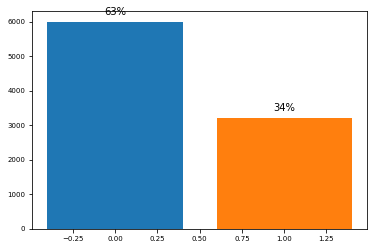

In [9]:
fig, ax = plt.subplots()
n = seen_df.shape[0]
for i, (name, group) in enumerate(seen_df.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

In [13]:
import pickle
revectorize = True
y = df['relevant']
if revectorize:
    vec = TfidfVectorizer(
        ngram_range=(1,1),
        min_df=4, max_df=0.8, strip_accents='unicode', 
        max_features=10000,
        use_idf=1,
        smooth_idf=1, sublinear_tf=1,
        stop_words="english",tokenizer=learning_utils.tokenize
    )
    ab_X = vec.fit_transform(df['content'])
    with open ('data/vec.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz('data/X.npz', ab_X)
else:
    with open ('data/vec.pickle','rb') as f:
        vec = pickle.load(f)
    ab_X = scipy.sparse.load_npz('data/X.npz')




/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [14]:
from sklearn.model_selection import KFold

models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []

kf = KFold(n_splits=10)
i=0
for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    i+=1
    for model in models:
        clf = model['model']
        model['i'].append(i)
        #clf = SVC(kernel='rbf',probability=True)
        clf.fit(ab_X[k_train],y[k_train])
        predictions = clf.predict(ab_X[k_test])
        model['e'].append(clf.score(ab_X[k_test],y[k_test]))
        # Precision
        model['p'].append(precision_score(predictions,y[k_test]))
        # Recall
        model['r'].append(recall_score(predictions,y[k_test]))

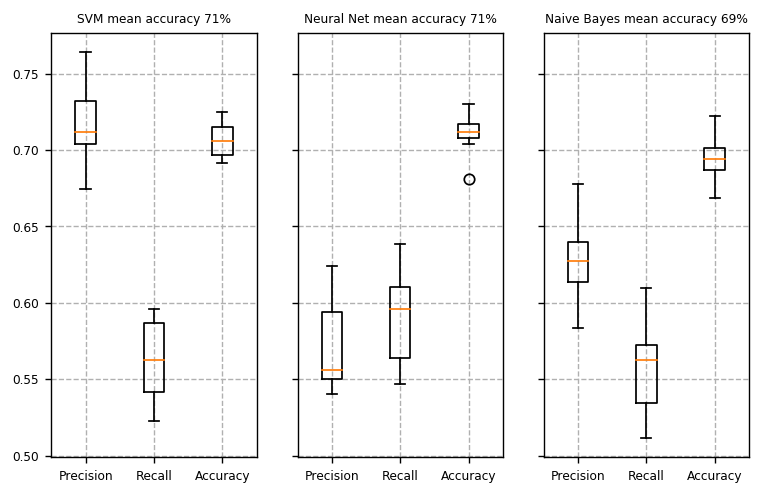

In [15]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(1,3,dpi=125,figsize=double_figure,sharey=True)
for i, model in enumerate(models):
    ax = axs[i]
    ax.boxplot([model['p'],model['r'], model['e']])
    
    ax.set_xticklabels(['Precision', 'Recall','Accuracy'])
    
    ax.set_title(f'{model["title"]} mean accuracy {np.mean(model["e"]):.0%}')
    ax.grid()
    
plt.show()

In [14]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
i=0
all_mistakes = None
df['mispredicted'] = 0


all_fps = None
all_fns = None

for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    
    clf = SVC(kernel='linear',class_weight='balanced',probability=True)
    clf.fit(ab_X[k_train],y[k_train])
    
    y_pred = clf.predict_proba(ab_X[k_test])
    
    fns = np.argwhere((np.array(y[k_test])>0.5) & (y_pred[:,1] < 0.5))
    fps = np.argwhere((np.array(y[k_test])<0.5) & (y_pred[:,1] > 0.5))
    
    print(f"mean prediction for false +ves {y_pred[fps,1].mean()}")
    print(f"mean prediction for false -ves {y_pred[fns,1].mean()}")
    
    mistakes = np.append(fps,fns)
    
    df.loc[k_test[mistakes],'mispredicted'] = 1
    
    if all_fps is not None:
        all_fps = np.append(all_fps,y_pred[fps,1][:,0])
    else:
        all_fps = y_pred[fps,1][:,0]
    if all_fns is not None:
        all_fns = np.append(all_fns,y_pred[fns,1][:,0])
    else:
        all_fns = y_pred[fns,1][:,0]    
        
        

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice.
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean prediction for false +ves nan
mean prediction for false -ves 0.35757629047836964


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice.
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean prediction for false +ves nan
mean prediction for false -ves 0.3570699892023384


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice.
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean prediction for false +ves nan
mean prediction for false -ves 0.3567427922192188


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice.
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean prediction for false +ves nan
mean prediction for false -ves 0.35936409067744646


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice.
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean prediction for false +ves nan
mean prediction for false -ves 0.3606092309274659


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice.
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean prediction for false +ves nan
mean prediction for false -ves 0.35744855467924047


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice.
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean prediction for false +ves nan
mean prediction for false -ves 0.35755150299420424


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice.
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean prediction for false +ves nan
mean prediction for false -ves 0.3568549947066671


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice.
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean prediction for false +ves nan
mean prediction for false -ves 0.3592455555165845
mean prediction for false +ves nan
mean prediction for false -ves 0.3597171373492723


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice.
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen,mispredicted
102,435846,Natural resource managers are seeking tools to...,Accelerating Adaptation of Natural Resource Ma...,climate change; community of practice; conserv...,[Biodiversity Conservation; Ecology; Environme...,1.0,1.0,1
126,322620,Local climate governance has become a key focu...,Local Climate Governance in the Global South: ...,local climate governing; green economy; networ...,[Environmental Studies],1.0,1.0,1
131,1801649,The Regional Approaches to Climate Change for ...,U.S. Inland Pacific Northwest Wheat Farmers' P...,agricultural adaptation; climate change; farme...,[Environmental Sciences],1.0,1.0,1
139,271937,Even with substantially increased attention to...,Developing local adaptation strategies for cli...,Climate change; Agriculture; Adaptation; Prior...,[Environmental Sciences; Environmental Studies...,1.0,1.0,1
146,382799,Sustainable Intensification (SI) of agricultur...,Evaluating the Sustainable Intensification of ...,None,None,1.0,1.0,1
165,1027334,Objectives of the paper are to explore the cur...,BUSINESS ENGAGEMENT IN ADAPTATION TO CLIMATE C...,Business Engagement; Adaptation; Climate Chang...,[Business],1.0,1.0,1
176,2478028,This article provides a synthesis of the forth...,At-a-glance - Climate change impacts on health...,None,None,1.0,1.0,1
179,813361,This article evaluates the proposition that fa...,Crops and livestock under the sun: Obstacles t...,climate change; dryland West Africa; land degr...,[Environmental Sciences; Soil Science],1.0,1.0,1
193,570593,This study provides an assessment of local gov...,The pace and progress of adaptation: Marine cl...,Adaptation; Climate change; Sea level rise; Co...,[Environmental Studies; International Relations],1.0,1.0,1
201,470758,The United Nations Framework Convention on Cli...,The application of an integrated national adap...,None,None,1.0,1.0,1


In [36]:
dos = DocOwnership.objects.filter(query=q,relevant__gt=0).order_by('id')
dodf = (pd.DataFrame.from_dict(dos.values('id','doc__id','user__username','start'))
        .rename(columns={"id":"do_id"})
       )

dodf.head()

,doc__id,do_id,start,user__username
0,44683,559672,None,apfisch@umich.edu
1,44683,559673,None,ee18ivc@leeds.ac.uk
2,44683,559674,None,l.berrangford@leeds.ac.uk
3,44683,559675,None,miriam@iri.columbia.edu
4,49638,559676,None,apfisch@umich.edu


In [37]:
mistakes = df[(df['mispredicted']==1) & (df['relevant']==1)]
print(mistakes.shape)
mistakes.head()

(3214, 8)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen,mispredicted
102,435846,Natural resource managers are seeking tools to...,Accelerating Adaptation of Natural Resource Ma...,climate change; community of practice; conserv...,[Biodiversity Conservation; Ecology; Environme...,1.0,1.0,1
126,322620,Local climate governance has become a key focu...,Local Climate Governance in the Global South: ...,local climate governing; green economy; networ...,[Environmental Studies],1.0,1.0,1
131,1801649,The Regional Approaches to Climate Change for ...,U.S. Inland Pacific Northwest Wheat Farmers' P...,agricultural adaptation; climate change; farme...,[Environmental Sciences],1.0,1.0,1
139,271937,Even with substantially increased attention to...,Developing local adaptation strategies for cli...,Climate change; Agriculture; Adaptation; Prior...,[Environmental Sciences; Environmental Studies...,1.0,1.0,1
146,382799,Sustainable Intensification (SI) of agricultur...,Evaluating the Sustainable Intensification of ...,None,None,1.0,1.0,1


apfisch@umich.edu


KeyError: 'mispredicted'

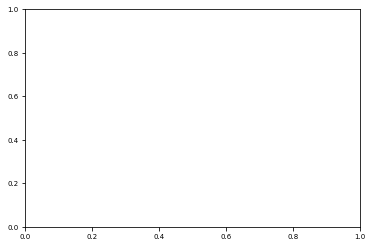

In [63]:
seen_do_df = (pd.merge(df[df['seen']==1],dodf,left_on="id",right_on="doc__id")
              .sort_values('do_id')
              .reset_index(drop=True)
             )
fig, ax = plt.subplots()
for name, group in seen_do_df.groupby('user__username'):
    print(name)
    ax.plot(group.reset_index(drop=True)['mispredicted'].cumsum(), label=name)
    
ax.legend()

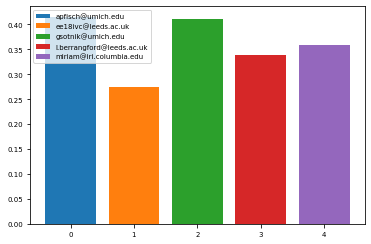

In [51]:
fig, ax = plt.subplots()
for i, (name, group) in enumerate(seen_do_df.groupby('user__username')):
    ax.bar(i, group['mispredicted'].sum()/group['seen'].sum(), label=name)
    
ax.legend()

In [50]:
seen_do_df[seen_do_df['user__username']=="gsotnik@umich.edu"].head()

,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen,mispredicted,doc__id,do_id,start,user__username
2634,6442,"In the context of climate change, adaptation t...",How adjustments in land use patterns contribut...,Climate change; Agricultural drought; Land use...,[Environmental Studies],1.0,1.0,1,6442,580119,None,gsotnik@umich.edu
2641,23569,Climate change adaptation (CCA) planning is an...,Cross-level differences and similarities in co...,Climate change; Adaptation planning; Cross-lev...,[Environmental Sciences],0.0,1.0,0,23569,580127,None,gsotnik@umich.edu
2645,32954,As an important agricultural production region...,"Information provision, policy support, and far...",Farm management measures; Determinants; Wheat;...,[Ecology],0.0,1.0,0,32954,580131,None,gsotnik@umich.edu
2649,42537,Farmers' risk attitude and risk perceptions ar...,Factors effecting farmers' risk attitude and r...,Catastrophic risk; Risk attitude; Risk percept...,"[Geosciences, Multidisciplinary; Meteorology &...",0.0,1.0,0,42537,580135,None,gsotnik@umich.edu
2653,57894,Adaptation to climate change is an inevitable ...,Farmers' initiative on adaptation to climate c...,Agricultural adaptation measures; Climate chan...,"[Geosciences, Multidisciplinary; Meteorology &...",1.0,1.0,1,57894,580139,None,gsotnik@umich.edu


In [16]:
clf =  MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )

#clf = SVC(kernel='linear',class_weight='balanced',probability=True)


clf.fit(ab_X[seen_index],y[seen_index])

y_pred = clf.predict_proba(ab_X[unseen_index])

In [17]:
len(seen_index)

9222

In [18]:
df['prediction'] = None
df.loc[unseen_index,'prediction'] = y_pred[:,1]

124
53166


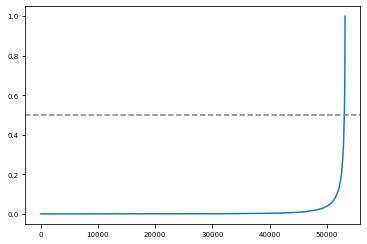

In [19]:
plt.close()

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])
print(pdf[pdf['prediction'].notna()].shape[0])

plt.show()

In [20]:
q = Query.objects.get(pk=qid)
q.users.all()

<QuerySet []>

In [21]:
q

<Query: published 2013+>

In [69]:
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

t1 = Tag(
    title="predicted relevant sample {}".format(now),
    query=q
)
t1.save()


tag = t1

users = q.users.all()
uc = len(users)
max_docs = 200
docs_added = 0
prel = True
for i, row in df.sort_values('prediction',ascending=False).head(3500).reset_index(drop=True).iterrows():
    d = Doc.objects.get(id=row['id'])
    if d.docownership_set.filter(query=q).exists():
        continue
    else:
        if docs_added < max_docs:
            d.tag.add(t1)
            docs_added+=1
        else:
            break  
        if row['prediction'] < 0.5 and prel:
            print(docs_added)
            prel = False

    
t1.update_tag()
#t2.update_tag()

29


In [70]:
df.to_csv(f'doctables/predictions_{now}.csv',index=False)

In [ ]:
tdf = pd.DataFrame({"a":[1,2,3,4]})
tdf.sample(frac=1, random_state=1)

In [ ]:
tdf = pd.DataFrame({"a":[1,2,3,4,5]})
tdf.sample(frac=1, random_state=1)